In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Nadam


In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)



all_classes_names = os.listdir(f'C:/Users/zaka/Desktop/FypData')
print(all_classes_names)

['Robbery', 'Testing_Normal_Videos_Anomaly']


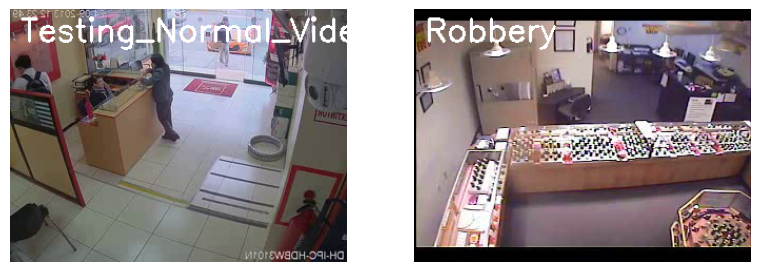

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'C:/Users/zaka/Desktop/FypData/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'C:/Users/zaka/Desktop/FypData/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [5]:
IMAGE_HEIGHT , IMAGE_WIDTH = 100, 100
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = f'C:/Users/zaka/Desktop/FypData/'
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = all_classes_names


In [6]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Robbery
Extracting Data of Class: Testing_Normal_Videos_Anomaly


In [10]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
from sklearn.model_selection import KFold

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed_constant)

In [11]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True,random_state = seed_constant)

In [13]:
len(features_train)

203

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    # 1st pass of LSTM
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'relu',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    # 2nd pass of LSTM
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 3rd pass of LSTM
    model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'relu', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    # model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
   
    model.add(Flatten()) 

    model.add(Dense(64, activation='relu'))

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [12]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
    video = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    cnn_base = VGG16(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                     weights="imagenet",
                     include_top= False)
    cnn_out = GlobalAveragePooling2D()(cnn_base.output)
    cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
    cnn.trainable = False
    encoded_frames = TimeDistributed(cnn)(video)
    encoded_sequence = LSTM(256)(encoded_frames)
    hidden_layer = Dense(units=64, activation="relu")(encoded_sequence)
    outputs = Dense(units=len(CLASSES_LIST), activation="softmax")(hidden_layer)
    model = Model([video],outputs)
    
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [13]:
convlstm_model = create_convlstm_model()
optimizer = Nadam(learning_rate=0.001,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      weight_decay=0.004)

print("Model Created Successfully!")
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Creating logs for tensorboard
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback, tensorboard_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 100, 100, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 30, 512)          14714688  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,518,722
Trainable params: 804,034
Non-trai

In [17]:
convlstm_model.save("new_model.h5")

In [18]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

: 

: 

In [1]:
convlstm_model = tf.keras.models.load_model('new_model.h5')

labelPred = convlstm_model.predict(features[:30])
y_true = labels_test.argmax(axis = 1)  # Actual values
y_pred = labelPred.argmax(axis = 1)  # Predicted values

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

NameError: name 'tf' is not defined

In [ ]:
cvscores = []
for train, test in kfold.split(features, one_hot_encoded_labels):
    # Construct the required convlstm model.
    convlstm_model = create_convlstm_model()
    # Display the success message. 
    print("Model Created Successfully!")
    early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
    convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
    convlstm_model_training_history = convlstm_model.fit(x = features[train], y = one_hot_encoded_labels[train], epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])
    scores = convlstm_model.evaluate(features[test], one_hot_encoded_labels[test], verbose=0)
    print("%s: %.2f%%" % (convlstm_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/fit

<h3>Below this is the better model </h3>

In [9]:
new_model = tf.keras.models.load_model('new_model_Zaka.h5')

In [10]:
labelPred = new_model.predict(features[:30])

: 

: 